# Neural Network Final Model - Mace Head, Ireland

In [1]:
import pandas as pd
from joblib import dump
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance

import sys
sys.path.append('../../')
import config

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'saved_files'

In [2]:
site = config.site
site_name = config.site_dict[site]
assert site == 'MHD', 'This script is only for Mace Head, Ireland. The site can be changed in the config file.'

compound = config.compound

print(f"Creating a neural network model for \033[1m{site_name}\033[0;0m.")

Creating a neural network model for Mace Head, Ireland.


### Loading & Initialising Data

In [3]:
data = pd.read_csv(data_path/f'for_model_{compound}_{site}.csv', parse_dates=['time'])
data.sample(5)

,time,flag,u10_0,u10_1,u10_2,u10_3,u10_4,u10_5,u10_6,u10_7,...,v500_7_past,v500_8_past,v500_9_past,v500_10_past,v500_11_past,v500_12_past,v500_13_past,v500_14_past,v500_15_past,v500_16_past
11503,1997-02-11 05:00:00,1.0,6.830777,15.692579,8.839367,8.202379,5.982528,4.433272,12.898159,7.564592,...,-6.853314,0.422875,2.694627,11.014505,-10.282343,-7.139753,-6.438473,1.313468,1.976885,13.208886
5056,1992-04-30 21:00:00,0.0,6.173993,14.633542,5.664463,5.952848,8.797851,11.580096,9.668237,7.422418,...,-7.939813,-1.302299,0.539424,-10.574477,-11.777398,-27.453497,-12.212801,-4.030719,3.174089,15.047563
39070,2017-06-01 23:00:00,0.0,3.910048,5.395973,0.089182,2.715550,-0.526575,2.262545,6.291993,7.697423,...,-0.083910,3.180630,11.049322,4.035337,6.704766,4.111257,-4.772553,-2.231698,6.240677,7.882743
31291,2011-11-04 19:00:00,1.0,4.289873,8.505770,2.064489,2.634778,1.086515,2.545229,5.447733,8.373016,...,2.245750,11.345844,25.134476,24.060125,14.696479,16.519520,2.554626,-15.617025,3.216024,11.092365
8683,1994-11-11 15:00:00,0.0,-7.608931,-11.055407,-5.116380,-2.339516,0.192274,4.606824,5.147788,2.766517,...,-0.427546,2.408293,-5.169497,-11.248136,-0.942277,-18.383580,-4.329843,9.683680,13.788650,3.260815


In [4]:
train_data = data[(data['time'].dt.year >= 2018) & (data['time'].dt.year <= 2018)]
val_data = data[(data['time'].dt.year >= 2019) & (data['time'].dt.year <= 2019)]
test_data = data[(data['time'].dt.year >= 2020) & (data['time'].dt.year <= 2023)]


print(f"Train range: {train_data['time'].min()} -> {train_data['time'].max()}. Length: {len(train_data)}")
print(f"Val range: {val_data['time'].min()} -> {val_data['time'].max()}. Length: {len(val_data)}")
print(f"Test range: {test_data['time'].min()} -> {test_data['time'].max()}. Length: {len(test_data)}")


# Drop the "time" column as it won't be used in the model
train_data = train_data.drop(columns=['time'])
val_data = val_data.drop(columns=['time'])
test_data = test_data.drop(columns=['time'])

# Define the features (X) and the target (y)
X_train = train_data.drop(columns=['flag'])
y_train = train_data['flag']
X_val = val_data.drop(columns=['flag'])
y_val = val_data['flag']
X_test = test_data.drop(columns=['flag'])
y_test = test_data['flag']

# Balanced Data - removing NaN values and associated data
y_train = y_train.dropna()
y_val = y_val.dropna()
y_test = y_test.dropna()

# aligning indices of features sets
X_train = X_train.loc[y_train.index]
X_val = X_val.loc[y_val.index]
X_test = X_test.loc[y_test.index]

Train range: 2018-01-01 01:00:00 -> 2018-12-31 01:00:00. Length: 1354
Val range: 2019-01-04 05:00:00 -> 2019-12-30 13:00:00. Length: 1067
Test range: 2020-01-02 17:00:00 -> 2022-12-31 19:00:00. Length: 3985


### Model

In [5]:
nn_model = MLPClassifier(random_state=42,
                         max_iter=1000, 
                         hidden_layer_sizes=(100,), 
                         shuffle=False,
                         activation='relu', 
                         solver='adam', 
                         alpha=0.5, 
                         learning_rate='constant', 
                         batch_size=100, 
                         early_stopping=True,
                         learning_rate_init=0.01,
                         beta_2=0.9,)

nn_model.fit(X_train, y_train)

class_probabilities_val = nn_model.predict_proba(X_val)
class_probabilities_train = nn_model.predict_proba(X_train)

confidence_threshold = 0.8

y_pred_val = (class_probabilities_val[:,1] > confidence_threshold).astype(int)
y_pred_train = (class_probabilities_train[:,1] > confidence_threshold).astype(int)

precision_val = precision_score(y_val, y_pred_val)
precision_train = precision_score(y_train, y_pred_train)
recall_val = recall_score(y_val, y_pred_val)
recall_train = recall_score(y_train, y_pred_train)
f1_val = f1_score(y_val, y_pred_val)
f1_train = f1_score(y_train, y_pred_train)

print(f"Precision on Training Set = {precision_train:.3f}")
print(f"Precision on Validation Set = {precision_val:.3f}")
print(f"Recall on Training Set = {recall_train:.3f}")
print(f"Recall on Validation Set = {recall_val:.3f}")
print(f"F1 Score on Training Set = {f1_train:.3f}")
print(f"F1 Score on Validation Set = {f1_val:.3f}")

Precision on Training Set = 0.899
Precision on Validation Set = 0.817
Recall on Training Set = 0.869
Recall on Validation Set = 0.873
F1 Score on Training Set = 0.884
F1 Score on Validation Set = 0.844


In [6]:
class_probabilities_test = nn_model.predict_proba(X_test)

y_pred_test = (class_probabilities_test[:,1] > confidence_threshold).astype(int)

precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"Precision on Testing Set = {precision_test:.3f}")
print(f"Recall on Testing Set = {recall_test:.3f}")
print(f"F1 Score on Testing Set = {f1_test:.3f}")

Precision on Testing Set = 0.888
Recall on Testing Set = 0.859
F1 Score on Testing Set = 0.873


In [7]:
# saving the model
dump(nn_model, data_path/f'nn_model_{site}.joblib')

['C:\\Users\\kirst\\OneDrive\\Kirstin\\Uni\\Year4\\MSciProject\\data_files\\saved_files\\nn_model_MHD.joblib']

### Assessing Feature Importance

In [8]:
# finding most important features in the model using permutation importance
# using the testing set
perm_importance = permutation_importance(nn_model, X_train, y_train, n_repeats=30, random_state=42)
sorted_importances = perm_importance.importances_mean.argsort()

Text(0.5, 0, 'Permutation Importance')

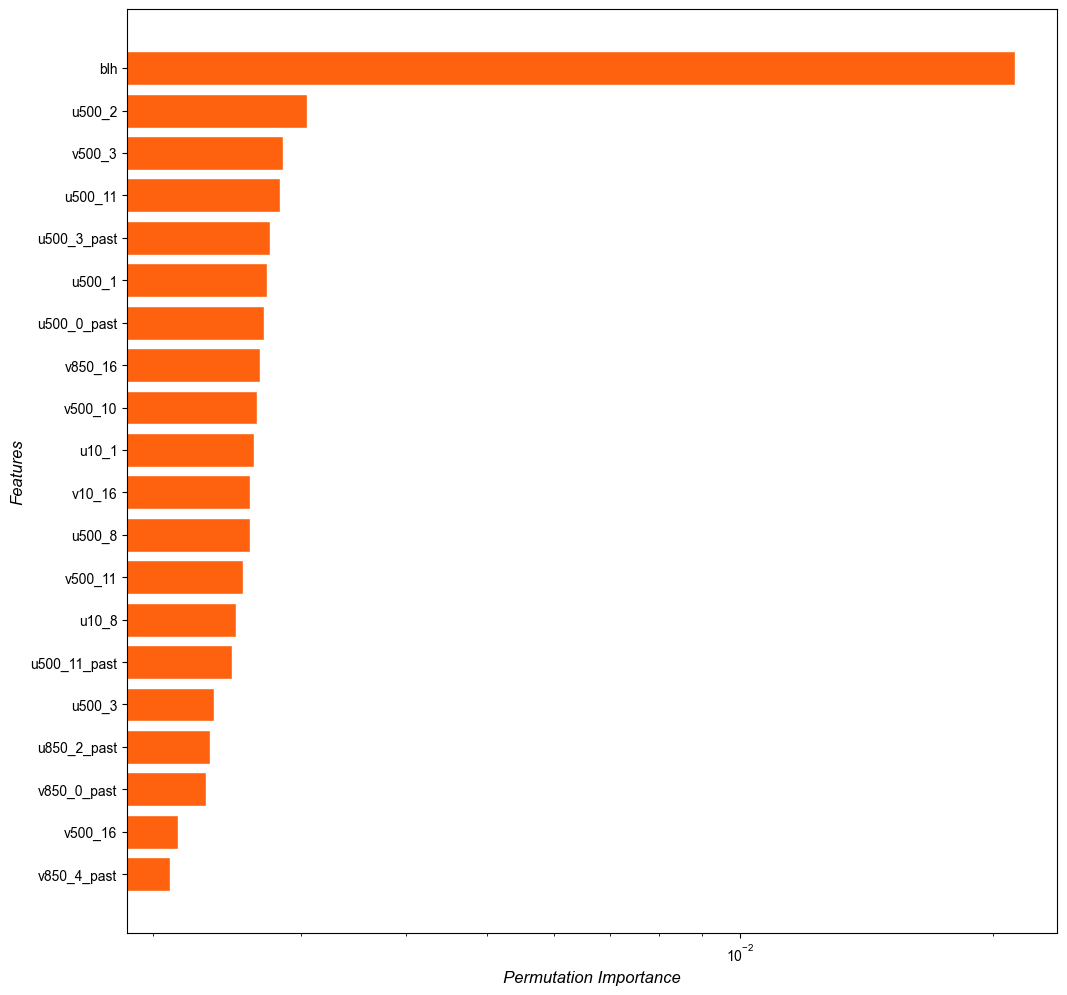

In [9]:
# plotting first 20 most important features in a histogram

fig, ax = plt.subplots(figsize=(12, 12))
sns.set_theme(style='ticks', font='Arial')

ax.barh(X_val.columns[sorted_importances][-20:], perm_importance.importances_mean[sorted_importances][-20:], color='#FF620E')

ax.set_xscale('log')

ax.set_ylabel('Features', fontsize=12, fontstyle='italic')
ax.set_xlabel('Permutation Importance', fontsize=12, fontstyle='italic')
# ax.set_title('Permutation Importance (Testing Set)', fontsize=14)